# **DQN-MARL Capacity sharing solution: A tutorial**


Welcome to the tutorial of the ***DQN-MARL capacity sharing*** solution, designed and developed by Mobile Communications Research Group (GRCM) of the Department of Signal Theory and Communications (TSC) of Universitat Politècnica de Catalunya (UPC). 

This tutorial aims at illustrating the operation of the training stage and inference stages of the DQN-MARL capacity sharing solution. A detailed description of the solution has been published in our paper: 
https://ieeexplore.ieee.org/abstract/document/9497684

### **Overview of the developed Python solution**

The developed solution relies on the TF-Agents library for creating multiple DQN Agents, each of the agents associated to a tenant. Each DQN agent learns the policy that allocates the capacity to the tenant in each of the cells of the network environment. To train the solution, a Python environment has been developed that simulates multiple cells and includes an scenario controller that manages the different cells and interacts with the different DQN Agents. 

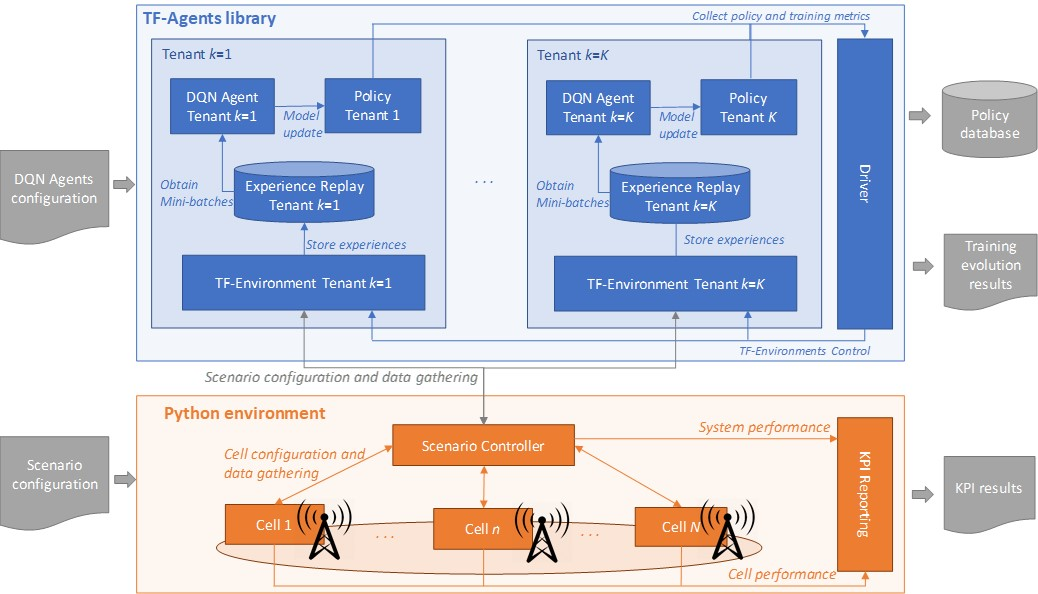



# **Developed Python Code**

The developed code is detailed in the following. 

## Set up and imports

To execute the code the following installations and imports are required. 


In [ ]:
pip install tf-agents

In [ ]:
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import os
import tempfile
import zipfile
import shutil
import statistics as st
from pandas import DataFrame
from itertools import product

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import policy_step
from tf_agents.specs import array_spec
from tf_agents.environments import py_environment
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()
tf.version.VERSION

'2.8.0'

## DQN Hyperparameters configuration

The DQN agents are configured according to the following hyperparameters: 

In [ ]:
initial_collect_steps = 5000  
collect_steps_per_iteration = 1  
replay_buffer_max_length = 10000000  
checkpoint_steps=5e4 
max_steps=5e5 # Number of steps for training
batch_size = 512  
learning_rate = 1e-4  
log_interval = 10  # 
n_eval = 1  
eval_interval =   1e3
fc_layer_params = (100,) #neural network params
dir_act = os.getcwd()

## 5G environment configuration

The following parameters specify the 5G environment, considering that the considered scenario for the tutorial is composed of two tenants and two cells:


In [ ]:
k_tenants=2 #Number of Tenants
n_BS=1 #Number of BSs
Nt=65 #Total number of PRBs in each cell
Seff=5 #Average Spectral efficiency in each cell
PRB_B=360e3 #PRB Bandwidth
Ct=Nt*Seff*PRB_B #Total capacity in the cell
Ct_allcells=Ct*n_BS #Total capacity in the system

pos_actions=[-3,0,3] #Possible actions per 
n_rep=5 #Number of repetitions for each row in the offered load files (simulation of time step duration)

## Load data for training

Data used for training is provided through csv files, which include the offered loads (traffic demand) of the tenants and their SLA values (*SAGBR* and *MCBR* parameters). 

The first step here is to upload de csv file for training.


In [ ]:
#The following steps are only required for the Colab tutorial (no local)
from google.colab import files
import io

file_training = files.upload()

The function *obtain_data_from_dataset*(...) processes the csv files for training and evaluation. 



In [ ]:
def obtain_data_from_dataset(df_data,n_rep, Ct_allcells, Ct):

  #Obtain data from each column (configure columns)
  dataT1=df_data.values.T[0].tolist()#Offered load Tenant 1
  dataT2=df_data.values.T[1].tolist()#Offered load Tenant 2
  SAGBR_perc_T1=df_data.values.T[2].tolist()#SAGBR Tenant 1
  SAGBR_perc_T2=df_data.values.T[3].tolist()#SAGBR Tenant 2
  MCBR_perc_T1=df_data.values.T[4].tolist()#SAGBR Tenant 1
  MCBR_perc_T2=df_data.values.T[5].tolist()#SAGBR Tenant 2

  O_k_T1=[]
  O_k_T2=[]
  SAGBR_k_T1=[]
  SAGBR_k_T2=[]
  MCBR_k_T1=[]
  MCBR_k_T2=[]

  #Process data
  for i in range(len(dataT1)): 
    for _ in range(n_rep):
      O_k_T1.append(dataT1[i]*Ct)
      O_k_T2.append(dataT2[i]*Ct)
      SAGBR_k_T1.append(SAGBR_perc_T1[i]*Ct_allcells)
      SAGBR_k_T2.append(SAGBR_perc_T2[i]*Ct_allcells)
      MCBR_k_T1.append(MCBR_perc_T1[i]*Ct)
      MCBR_k_T2.append(MCBR_perc_T2[i]*Ct)
  O_k_n=[O_k_T1,O_k_T2]
  SAGBR=[SAGBR_k_T1,SAGBR_k_T2]
  MCBR=[MCBR_k_T1,MCBR_k_T2]

  return O_k_n, SAGBR, MCBR

Training data is obtained and processed: 

In [ ]:
chunk_size=5000 #Training data is read in chunks of data. 
O_k_T1_train=[]
O_k_T2_train=[]
SAGBR_k_T1_train=[]
SAGBR_k_T2_train=[]
MCBR_k_T1_train=[]
MCBR_k_T2_train=[]

file_training_name='training_data_short.csv'
#Import traffic from csv for training
data_train = pd.read_csv(file_training_name, sep=';',header=None, chunksize=chunk_size) #Obtain data in chunks
data_train_firstchunk=next(data_train)
O_k_n_train, SAGBR_train, MCBR_train=obtain_data_from_dataset(data_train_firstchunk,n_rep,Ct_allcells, Ct)



## Python environment for multi-cell scenarios
A Python environment that emulates the network operation is created. This relies on two main classes: the class *BS* and the class *BS_controller*. These include all the data required to compute the states and rewards according to the sent actions by the different DQN agents. 



### Class *BS*
This class represents a single base station (or cell) in the environment. It includes the following class functions: 


*   _init_( ): Initialization of the BS object.
*   _reset_( ): Reset according to a initial share.
*   _get_state_( ): Resturns the state of a tenant in the BS.
*   _get_performance_( ): Returns the performance of a tenant in the BS. 
*   _set_action_( ): Notifies the action of a tenant in the cell. 
*   _inform_system_thr_( ): Provides info of the total system throughput of a tenant to support the application of actions. 
*   _apply_actions_( ): Applies the notified actions of all tenants and verifies that only the cell capacity is assigned (not more). 
*   _run_( ): Runs a time step in the BS and computes the performance. 
*   _import_data_chunk_BS_( ): Load a chunk of data to the BS (only used for training). 





In [ ]:
class BS():

    def __init__(self,k_tenants,BS_id,Nt,Seff,PRB_B,initial_share,SAGBR,MABR,O_k_n):
        self.k_tenants=k_tenants
        self.BS_id=BS_id
        self.Nt=Nt
        self.Seff=Seff
        self.PRB_B=PRB_B
        self.Ct=self.Nt*self.Seff*self.PRB_B
        self.share=initial_share
        self.MABR=MABR 
        self.SAGBR=SAGBR       
        self.O_k=O_k_n      
        self.Thr_k=[[],[]]
        self.pG_k=[[],[]]
        self.time_step=0 #number of time steps performed
        self.time_step_chunk=0
        self.total_steps=len(self.O_k[0])
        self.SThr=[[],[]]

        #Params to evaluate       
        self.action_history=[[0],[0]] #It is considered that the first action is 0
        self.share_history=[[0.6],[0.4]]
        
    def reset(self,share):
        self.time_step=0
        self.time_step_chunk=0
        self.share=share
        self.Thr_k=[[],[]]
        self.pG_k=[[],[]]
        self.action_history=[[0],[0]]
        self.share_history=[[0.6],[0.4]]

    #Get the current state
    def get_state(self,tenant):   
          
        total_pG=0
        for i in range(self.k_tenants):
            total_pG+=self.pG_k[i][-1]

        return [self.pG_k[tenant][-1],self.share[tenant],max(1-sum(self.share),0),max(1-total_pG,0)]

    #Provide return parameters [Cthr, pg_k,Ok_real, Ok_modif, C_ass_n]
    def get_performance(self,tenant):
        return [self.Thr_k[tenant][-1],self.pG_k[tenant][-1],self.O_k[tenant][self.time_step_chunk-1],min(self.O_k[tenant][self.time_step_chunk-1],self.MABR[tenant][self.time_step_chunk-1]),self.Ct*self.share[tenant]]

    #Configure a new action
    def set_action(self,action,tenant):
        self.action_history[tenant].append(action)

    def inform_system_thr(self,SThr,tenant):
        self.SThr[tenant]=SThr      

    def apply_actions(self):
        #Compute expected share with last actions
        expected_share=np.zeros(self.k_tenants)
        last_action=np.zeros(self.k_tenants) #used to identify
        for k in range(self.k_tenants):
            expected_share[k]=self.share[k]+self.action_history[k][-1]/100
            last_action[k]=self.action_history[k][-1]
            if expected_share[k]>self.MABR[k][self.time_step_chunk]/self.Ct:
                expected_share[k]=self.MABR[k][self.time_step_chunk]/self.Ct
                last_action[k]=0
            elif expected_share[k]<0:
                expected_share[k]=0
                last_action[k]=0

        #Check if conflict
        if sum(expected_share)<=1: #No conflict
            self.share=expected_share
        else: #conflict: summation of share is larger than 1
            #If there are no enough resources, those tenants above SAGBR cannot increase their PRBs
            tenants_no_increase = [item.tolist() for item in np.where(np.array(last_action)<=0)][0] #Index of tenants that do not increase
            tenants_increase=[item.tolist() for item in np.where(np.array(last_action)>0)][0] #Index tenants that want to increase

            for k in tenants_no_increase: #Apply actions of tenants that do not ask to increase
                self.share[k]=expected_share[k]

            traffic_below=0
            for k in tenants_increase: #detect if there are tenants with traffic below SAGBR
                if self.SThr[k]<self.SAGBR[k][self.time_step_chunk]:
                    traffic_below=1

            for k in tenants_increase:
                if self.SThr[k]>self.SAGBR[k][self.time_step_chunk] and traffic_below==1: #those that are above SAGBR need to decrease if there is some that is below
                    last_action[k]=-self.action_history[k][-1]
                    expected_share[k]=self.share[k]+last_action[k]/100
                    self.share[k]=expected_share[k]
                    
            tenants_increase=[item.tolist() for item in np.where(np.array(last_action)>0)][0] #Index tenants that want to increase (update)

            if sum(self.share)<1: #If the result decreasing or and 0 actions give 1, do nothing. Else:
                denom=sum([self.SAGBR[k][self.time_step_chunk] for k in tenants_increase])
                Av_share=1-sum(self.share)
                #actions_tenants_increase=[self.action_history[k][-1] for k in tenants_increase]
                action_sharing=np.zeros(self.k_tenants)
                for k in tenants_increase: 
                    action_sharing[k]=(self.SAGBR[k][self.time_step_chunk]/denom) 
                    self.share[k]=self.share[k]+Av_share*action_sharing[k]/100 #Share according to last SLA
            
        for k in range(self.k_tenants):
            self.share_history[k].append(self.share[k])

    #Execute the environment for a step
    def run(self): 

        #Apply actions set by agents in the environment
        self.apply_actions()
        
        #Obtain current slice throughput and occupation
        total_thr=0
        for k in range(self.k_tenants):
            if self.O_k[k][self.time_step_chunk]<self.share[k]*self.Ct:
                self.Thr_k[k].append(self.O_k[k][self.time_step_chunk])
                
            else:
                self.Thr_k[k].append(self.share[k]*self.Ct)
                
            total_thr+=self.Thr_k[k][-1]
               
        #Compute occupation 
        for k in range(self.k_tenants):
            self.pG_k[k].append(self.Thr_k[k][-1]/self.Ct)
                     
        self.time_step+=1
        self.time_step_chunk+=1

    def import_data_chunk_BS(self, O_chunk_k_n, SAGBR_chunk, MCBR_chunk):
        self.O_k_n=O_chunk_k_n
        self.SAGBR=SAGBR_chunk
        self.MABR=MCBR_chunk
        self.time_step_chunk=0

### Class *BS_controller*

This class acts both as a manager of the different BSs and as an intermediary between the DQN Agents and the BSs in the scenario. In includes the following class functions:

*   _init_( ): Initialization of the BS Controller object.
*   _initialise_BS_( ): Initializes all the BSs in the scenario. 
*   _reset_( ): Reset the BS controller and the BSs. 
*   _get_state_( ): Returns the state of a tenant in the system for the current time step. 
*   _get_reward_( ): Computes the reward of a tenant for the current time step. 
*   _set_action_( ): Notifies the action of a tenant to the different BSs and informs of the system throughput to each of them.
*   _run_( ): Runs a time step in the different BSs and computes and gathers their performance.
*   _import_data_chunk_BS_( ): Loads a chunk of data to the different BSs (only used for training).
*   _initialise_params_time_step_( ): Initialize parameters in a time step
*   _next_time_step_( ): Performs the actions to move to the following time step. 

In [ ]:
class BS_controller():
  def __init__(self,k_tenants,n_BS,Nt,Seff,PRB_B,Ct,SAGBR,MABR,O_k_n):
    self.k_tenants=k_tenants
    self.n_BS=n_BS

    #BS_configuration
    self.Nt=Nt
    self.Seff=Seff
    self.PRB_B=PRB_B
    self.Ct=Ct
    self.SAGBR=SAGBR
    self.MABR=MABR
    self.initial_share=[self.SAGBR[k][0]/sum([self.SAGBR[i][0] for i in range(len(self.SAGBR))]) for k in range(self.k_tenants)]
    self.reward_factors=[0,0,0.5,0.4]
    self.BS_set=[] 
    self.total_capacity=self.n_BS*self.Ct

    self.O_k_n=O_k_n

    self.initialise_BS()

    self.total_steps=len(self.O_k_n[0]) #Total time steps to perfrom
    self.time_step=0 #number of time steps performed
    self.time_step_chunk=0 #time step in the current chunk of data

    self.reward_history=[[0],[0]]
    self.fi_SLA_history=[[1],[1]]
    self.fi_ut_history=[[0],[0]]
    self.fi_extra_history=[[0],[0]]
    self.total_O_k_history=[[0],[0]]
    self.beta_k_history=[[0],[0]]
    self.Thr_k=[[],[]]#System level throughput (sumation of all BS)
    self.pG_k=[[],[]]
    self.O_k=[[],[]]
    self.O_k_modif=[[],[]]
    self.C_ass_k=[[],[]]
    
    self.run()


  def initialise_BS(self):
      for n in range(self.n_BS): 
          self.BS_set.append(BS(self.k_tenants,n,self.Nt,self.Seff,self.PRB_B,self.initial_share,self.SAGBR,self.MABR,self.O_k_n))

  def reset(self):
      for n in range(self.n_BS):
          self.BS_set[n].reset(self.initial_share)
      self.time_step=0 #number of time steps performed
      self.time_step_chunk=0 #time step in the current chunk of data
      self.reward_history=[[0],[0]]
      self.fi_SLA_history=[[1],[1]]
      self.fi_ut_history=[[0],[0]]
      self.fi_extra_history=[[0],[0]]
      self.total_O_k_history=[[0],[0]]
      self.beta_k_history=[[0],[0]]
      self.Thr_k=[[],[]]#System level throughput (sumation of all BS)
      self.pG_k=[[],[]]
      self.O_k=[[],[]]
      self.O_k_modif=[[],[]]
      self.C_ass_k=[[],[]]

      self.run()

  def get_state(self,tenant):
      pG_k=[]
      share_k=[]
      av_share_k=[]
      av_pg_k=[]
      MCBR=[]    
      
      for n in range(self.n_BS):
          BS_state=self.BS_set[n].get_state(tenant)
          pG_k.append(BS_state[0]) # ocupation
          share_k.append(BS_state[1]) #tenant's share
          av_share_k.append(BS_state[2]) #Share not used by any tenant
          av_pg_k.append(BS_state[3])
          MCBR.append(self.MABR[tenant][self.time_step_chunk]/self.BS_set[n].Ct)
          

      #Last row --> SAGBR(k), SAGBR_others, 0, 0 ,0
      pG_k.append(self.SAGBR[tenant][self.time_step_chunk]/self.total_capacity)
      SAGBR_others=0
      for i in range(self.k_tenants):
          if i!=tenant:
              SAGBR_others+=self.SAGBR[i][self.time_step_chunk]
      share_k.append(SAGBR_others/self.total_capacity)
      av_share_k.append(0)
      av_pg_k.append(0)
      MCBR.append(0)

      return [pG_k,share_k,av_share_k,av_pg_k,MCBR]

  def get_reward(self,tenant):
      fi_SLA_tenants=np.ones(self.k_tenants)
      fi_ut=0
      fi_extra=1
      sum_Thr=0

      for k in range(self.k_tenants):
          if self.O_k_modif[k][-1]>0:
              sla_ratio=self.Thr_k[k][-1]/min(self.O_k_modif[k][-1],self.SAGBR[k][self.time_step_chunk])   
              fi_SLA_tenants[k]=min(sla_ratio,1)
              sum_Thr+=self.Thr_k[k][-1]

      fi_SLA_othertenants=1/(self.k_tenants-1)*sum(fi_SLA_tenants[k] for k in range(self.k_tenants) if k!=tenant)
      fi_SLA=fi_SLA_tenants[tenant]

      if self.C_ass_k[tenant][-1]>0:
          fi_ut=self.Thr_k[tenant][-1]/(self.C_ass_k[tenant][-1])
      elif self.O_k_modif[tenant][-1]==0:
          fi_ut=1

      total_O_k=0
      beta_k=0 #extra capacity not required by other tenants
      for k in range(self.k_tenants):
          total_O_k+=self.O_k_modif[k][-1]
          if k!=tenant:
              beta_k+=max(self.SAGBR[k][self.time_step_chunk]-self.O_k_modif[k][-1],0)

      if self.O_k_modif[tenant][-1]==0:
          fi_extra=1
      elif total_O_k>self.total_capacity:
          fi_extra=min(self.Thr_k[tenant][-1]/min(self.SAGBR[tenant][self.time_step_chunk]+beta_k,self.O_k_modif[tenant][-1]),1)
      else:
          fi_extra=self.Thr_k[tenant][-1]/self.O_k_modif[tenant][-1]
    
      reward=(fi_SLA**self.reward_factors[0])*(fi_SLA_othertenants**self.reward_factors[1])*(fi_ut**self.reward_factors[2])*(fi_extra**self.reward_factors[3])

      self.reward_history[tenant].append(reward)
      self.fi_SLA_history[tenant].append(fi_SLA)
      self.fi_ut_history[tenant].append(fi_ut)
      self.fi_extra_history[tenant].append(fi_extra)
      self.total_O_k_history[tenant].append(total_O_k)
      self.beta_k_history[tenant].append(beta_k)
      
      return reward

  def set_action(self,actions,tenant):
      for n in range(self.n_BS):
          self.BS_set[n].set_action(actions[n],tenant)
          self.BS_set[n].inform_system_thr(self.Thr_k[tenant][-1],tenant)

  def run(self): 
      Thr=np.zeros(self.k_tenants)
      pG=np.zeros(self.k_tenants)
      Oreal_k=np.zeros(self.k_tenants)
      Omodif_k=np.zeros(self.k_tenants)
      C_ass=np.zeros(self.k_tenants)

      for n in range(self.n_BS):
          self.BS_set[n].run()

          #Gather throughput and occupation
          for k in range(self.k_tenants):
              results=self.BS_set[n].get_performance(k)
              Thr[k]+=results[0]
              pG[k]+=results[1]
              Oreal_k[k]+=results[2]
              Omodif_k[k]+=results[3]
              C_ass[k]+=results[4]
      
      #Store performance data- Required for reward computation
      for k in range(self.k_tenants):
          self.Thr_k[k].append(Thr[k])
          self.pG_k[k].append(pG[k])
          self.O_k[k].append(Oreal_k[k])
          self.O_k_modif[k].append(Omodif_k[k])
          self.C_ass_k[k].append(C_ass[k])    

      self.time_step+=1
      self.time_step_chunk+=1

  def import_data_chunk(self, O_chunk_k_n, SAGBR_chunk, MCBR_chunk):
      self.O_k_n=O_chunk_k_n
      self.SAGBR=SAGBR_chunk
      self.MABR=MCBR_chunk
      self.time_step_chunk=0

      for n in range(self.n_BS):
          self.BS_set[n].import_data_chunk_BS(O_chunk_k_n,SAGBR_chunk,MCBR_chunk)

  def initialise_params_time_step(self): 
      for k in range(self.k_tenants):
          self.Thr_k[k].append(0)
          self.pG_k[k].append(0)
          self.O_k[k].append(0)
          self.O_k_modif[k].append(0)
          self.C_ass_k[k].append(0)

          for n in range(self.n_BS): 
              self.BS_set[n].Thr_k[k].append(0)
              self.BS_set[n].pG_k[k].append(0)      

  def next_time_step(self):
      for k in range(self.k_tenants):
          self.get_reward(k)
      for n in range(self.n_BS): 
          self.BS_set[n].next_time_step_BS()
      self.time_step+=1
      self.time_step_chunk+=1

###Creation of BS controller object 
Relaying on the above classes, BSs controller for training is created. Note that the BS controller is loaded with training data. The individual BSs associated are created during the init function of the corresponding BS controller. 





In [ ]:
bs_controller=BS_controller(k_tenants,n_BS,Nt,Seff,PRB_B,Ct,SAGBR_train,MCBR_train,O_k_n_train) #BS controller for training

###Class *environment_5G_multipleBS*

To enable the interaction between the BS_controller and the different DQN agents, an Python environment class needs to be created for each of DQN agent. This Python environment inherits from the TF-Agents class *py_environment.PyEnvironment*, which establishes the class functions as well as their inputs and outputs. The developed class for the DQN-MARL capacity sharing solution has been denoted as *environment_5G_multipleBS*( ) and the class includes the following functions: 

*   _init_( ): Initializes the environment. The environment is associated to a BS_controller and includes the specification of the actions and states (observations). 
*   _action_spec_( ): Returns the specification (format) of actions. 
*   _observation_spec_( ): Returns the specification (format) of states (observations).
*   _reset_( ): Resets the environment, including the BS_controller. 
*   _step_( ): Runs a time step in the system, obtaining the state and the reward from the BS controller and setting the actions for the different cells also through the BS controller. 

In [ ]:
class environment_5G_multipleBS(py_environment.PyEnvironment):

    def __init__(self,tenant_id,bs_controller,pos_actions):

        self.tenant_id=tenant_id
        self.bs_controller=bs_controller

        self.possible_actions_cell=pos_actions
        self.n_BS=self.bs_controller.n_BS

        self.possible_actions=[val for val in product(self.possible_actions_cell,repeat=self.n_BS)]
        self.n_actions=len(self.possible_actions)
        
        #Set format of actions. Possible actions of an agent considering
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int64, minimum=0, maximum=self.n_actions-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(5,self.n_BS+1), dtype=np.float32, minimum=0, name='observation')
            #For each state defined by the <pg, share_k, share_ava, 1-sum(pg), MCBR(n)> for each BS
            #Last row, SAGBR(k) and sum(SAGBR(k') for k'=!k)
        
        self.last_action=0
        self._state=self.bs_controller.get_state(self.tenant_id)
        self._episode_ended=False       

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.bs_controller.reset()
        self._state = self.bs_controller.get_state(self.tenant_id)
        self.last_action=0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))

    def _step(self, action):   
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Obtain state after action
        self._state=self.bs_controller.get_state(self.tenant_id)
        # Obtain reward after last action
        self.reward=self.bs_controller.get_reward(self.tenant_id)

        # Construct step to return
        if self._episode_ended:
            next_step=ts.termination(np.array(self._state, dtype=np.float32), self.reward)
        else:
            next_step=ts.transition(np.array(self._state, dtype=np.float32), reward=self.reward, discount=0.9)
        
        if isinstance(action,np.ndarray):
            action=action.take(0)

        #Translate action
        action_trans=self.possible_actions[action]
 
        # Apply new action
        self.bs_controller.set_action(action_trans, self.tenant_id)
        self.last_action=action

        # Return last experience turple
        return next_step

### Creation of Python and TF-environments

A Python *environment_5G_multipleBS* environment is created for each agent. The Python environment requires to be transformed to a TF-environment in order to interact with the TF-Agents DQN Agents. 

In [ ]:
#Generate Python environments for training
env_tenants_py=[]
env_tenants_tf=[]
for k in range(k_tenants):
  env_tenants_py.append(environment_5G_multipleBS(k,bs_controller,pos_actions))

#Generate tf environment for training
for k in range(k_tenants):
  env_tenants_tf.append(tf_py_environment.TFPyEnvironment(env_tenants_py[k]))
  env_tenants_tf[k].reset() #Initialise

## Creation of DQN Agents

For the creation of the DQN Agents associated to each tenant, the following elements are required: 

*   Deep Neural Network (A Q Network is used).
*   Optimizer (Adam Optimizer is used).

Moreover, for each of the DQN Agents, a Replay Buffer is created and a random policy object is also created. All these objects are created based on the TF-Agents library. 



In [ ]:
q_network_tenants=[]
optimizer_tenants=[]
agents_tenants=[]
tf_policy_savers=[]
policy_dirs=[]
random_policy_tenants=[]
replay_buffer_tenants=[]

print('Creating agents, polices and reply buffers...')
#Create the agent,random policy and replay buffer for each of the tenants
for k in range(k_tenants):
  #Deep Neural network
  q_network_tenants.append(q_network.QNetwork(
      env_tenants_tf[k].observation_spec(),
      env_tenants_tf[k].action_spec(),
      fc_layer_params=fc_layer_params))

  optimizer_tenants.append(tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate))

  global_step = tf.compat.v1.train.get_or_create_global_step() 

  agents_tenants.append(dqn_agent.DqnAgent(
      env_tenants_tf[k].time_step_spec(),
      env_tenants_tf[k].action_spec(),
      q_network=q_network_tenants[k],
      optimizer=optimizer_tenants[k],
      td_errors_loss_fn=common.element_wise_squared_loss,
      train_step_counter=global_step))
  agents_tenants[-1].initialize() #Initialise last agent

  random_policy_tenants.append(random_tf_policy.RandomTFPolicy(env_tenants_tf[k].time_step_spec(),
                                                env_tenants_tf[k].action_spec()))

  replay_buffer_tenants.append(tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agents_tenants[k].collect_data_spec,
      batch_size=env_tenants_tf[k].batch_size,
      max_length=replay_buffer_max_length))
  
  print('Created done')

Creating agents, polices and reply buffers...


##Collection of experiences

The different DQN agents in the solution interact with the environment synchronously in order to gather experiences composed by tuples composed of the last state and action and the resulting reward and state (i.e.,  <s(t-1), a(t-1), s(t), r(t)>). The experiences of each agent are stored in its experience replay. 

Different functions have been created to manage the collection of experiences by the different agents: 

#### *Collect_Step*( )

Function that collects a single step of an agent. At each time step, the previous state of the agent is obtained in the variable *time_step*, as well as and the last performed action *last_action*, which had been stored in the environment. Then, a new action *action_new* is selected according to the policy and is sent to the environment. This provides a new *next_time_step* variable containing the state and reward obtained from action *last_action*. The trajectory (i.e., experience) is stored in the buffer (i.e. experience dataset). 

Note that the experiences in this function are stored in the experience dataset a posteriori, which is not the regular operation of the DQN algorithm in TF-Agents. This method has been developed in order to enable the multi-agents operation in a synchronous manner. 



In [ ]:
def collect_step(env, policy, buffer):
  #Obtain previous time step 
  time_step = env.current_time_step()
  #Obtain last performed action and put it in policystep format
  last_action=policy_step.PolicyStep(tf.constant(np.array([env.pyenv.envs[0].last_action]))) 
  #Obtain new action to send to the environment
  action_new = policy.action(time_step)
  #Obtain state and reward after the last action and send new action to the environment 
  next_time_step = env.step(action_new.action)
  #Construct trajectory from last experience
  traj = trajectory.from_transition(time_step, last_action, next_time_step)
  
  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

#### *Collect_step_MA*( )

Function that collects a step from a multiple agents. The function calls the *collect_step* function for the different agents (tenants) by providing as input parameters the environment, policy and experience replay buffer of each agent. 

Afterwards, the function executes the step in the *bs_controller* in order to apply the actions of the policies of the different agents selected inside *collect_step*. 


In [ ]:
def collect_step_MA(envs, polices, buffers, bs):
  for k in range(bs_controller.k_tenants):
    collect_step(envs[k],polices[k],buffers[k])
  bs_controller.run()

#### *Collect_data_MA*( )

Function that collects a multiple steps (variable *steps*) from a multiple agents. The function calls the *collect_step_MA* function *steps* times. 

In [ ]:
def collect_data_MA(envs, polices, buffers, bs_controller, steps):
  for s in range(steps):
    if s%100==0:
      print('Step: ',s)
    collect_step_MA(envs, polices, buffers, bs_controller)

## Initial collection of experiences

The dataset experiences of the different DQN agents is initialized with a set of experiences collected according to the random policy created previously for each tenant. The random_policy is executed *initial_collect_steps* times. 

This stage is fundamental for the learning of the policies of each DQN, since a full exploratory behaviour is obtained so the DQN agent can experient several states and actions that will not be experiented when the e-Greedy policy is used during the training stage. In order to achieve the learning, the lenght of *initial_collect_steps* should be at least larger than the number of possible actions in the environment. 

In [ ]:
collect_data_MA(env_tenants_tf, random_policy_tenants, replay_buffer_tenants, bs_controller, steps=100)

## Training 

The training process consists in the process of gathering of experiences according to a ɛ-Greedy policy and the update of the policies of the different agents. The training is conducted during *max_steps*. Since training datasets are usually large, the data in the training datset files are read in chunks. 

This example, the evolution of the training is depicted in terms of the loss

In [ ]:
# Reset the train step
for k in range(k_tenants):
  agents_tenants[k].train_step_counter.assign(0)

dataset=[]
iterator=[]
chunk_number=1
train_loss_buffer=[[] for _ in range(k_tenants)]
train_loss=[[] for _ in range(k_tenants)]
interv_loss=[]

#Prepare dataset of experiences
for k in range(k_tenants):
  dataset.append(replay_buffer_tenants[k].as_dataset(
  num_parallel_calls=3,
  sample_batch_size=batch_size, 
  num_steps=2).prefetch(3))

  iterator.append(iter(dataset[-1]))

max_steps=2e5
for it in range(bs_controller.time_step,int(max_steps)):
  if it%log_interval==0:
    print('Iteration: ',it,)

  #keep reading chunks from file
  if bs_controller.time_step%(chunk_size*n_rep)==0: 
    data_train_chunk=next(data_train)
    O_k_n_train, SAGBR_train, MCBR_train=obtain_data_from_dataset(data_train_chunk,n_rep,Ct_allcells, Ct)
    bs_controller.import_data_chunk(O_k_n_train,SAGBR_train,MCBR_train)
    chunk_number+=1
    print('Chunk '+str(chunk_number)+' imported...')

  #Generate collecting polices for the iteration 
  collecting_polices=[]
  for k in range(k_tenants):
    collecting_polices.append(agents_tenants[k].collect_policy)

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step_MA(env_tenants_tf, collecting_polices, replay_buffer_tenants, bs_controller)

  # Sample a batch of data from the buffer and update the agent's network.
  for k in range(k_tenants):
    experience, unused_info = next(iterator[k])
    train_loss[k] = agents_tenants[k].train(experience).loss
    step = agents_tenants[k].train_step_counter.numpy()

  #For showcase
  if (it-1) %log_interval ==0:
    for k in range(k_tenants):
      train_loss_buffer[k].append(train_loss[k])
    interv_loss.append(it-1)

Plot training evolution

In [ ]:
import matplotlib.pyplot as plt

for k in range (k_tenants):
  plt.plot(interv_loss, train_loss_buffer[k], label="Loss tenant "+str(k))

plt.plot()

plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.legend()
plt.show()

##Evaluation

To evaluate the performance of the learnt policies by the DQN agents, the policies can be applied in inference mode (Greedy policy) to an evaluation offered loads and SLA parameters. For the evaluation of the policies the following steps are followed: 





**1.   Import and process evaluation data files**: These functions are the same as the ones used for obtaining the data for training. 

In [ ]:
#The following steps are only required for the Colab tutorial (no local)
file_evaluation= files.upload()

file_evaluation_name='eval_data.csv'
#Import traffic from csv for evaluation final
data_eval = pd.read_csv(file_evaluation_name,sep=';',header=None) #Obtain the whole file (shorter)
O_k_n_eval, SAGBR_eval, MCBR_eval=obtain_data_from_dataset(data_eval,n_rep,Ct_allcells, Ct)

Saving eval_data.csv to eval_data.csv


**2.   Generation of environment(s) for evaluation**: A new environment needs to be generated for the evaluation for each tenant in the evaluation scenario. This includes a *BS_controller*, and for each agent a python environment and a tf-environment: 

In [ ]:
#Generate a BS controller for evaluation
bs_controller_eval=BS_controller(k_tenants,n_BS,Nt,Seff,PRB_B,Ct,SAGBR_eval,MCBR_eval,O_k_n_eval) #BS controller for evaluation

#Generate Pythonenvironments for evaluation
env_tenants_py_eval=[]
env_tenants_tf_eval=[]
for k in range(k_tenants):
  env_tenants_py_eval.append(environment_5G_multipleBS(k,bs_controller_eval,pos_actions))

#Generate tf environment for evaluation
for k in range(k_tenants):
  env_tenants_tf_eval.append(tf_py_environment.TFPyEnvironment(env_tenants_py_eval[k]))
  env_tenants_tf_eval[k].reset() #Initialise

**3.  Obtain Greedy policies for evaluation**: Extract the greedy policy for evaluation from the DQN agents of training. 

In [ ]:
eval_polices=[]
for k in range(k_tenants):
  eval_polices.append(agents_tenants[k].policy) #Generate greedy policy to evaluate
  

**4. Evaluate the Greedy policies in the evaluation environments and extract results**: For this purpose, the *evaluation*() function has been generated that applies the Greedy policies to the evaluation data and includes a the *export_results*() function to export the desired Key Performance Metrics (KPIs).

*Evaluation*( ) function

In [ ]:
def evaluation(k_tenants,n_BS,bs_controller_eval,env_tenants_tf_eval,polices,file_name):
  print('Starting Evaluation...')
  #Reset evaluation environment
  for k in range(k_tenants):
    env_tenants_tf_eval[k].reset() #Initialise

  for i in range(bs_controller_eval.total_steps-1):
    if i%50==0:
      print('Evaluation Step: ',i)
    for k in range(k_tenants):
      time_step = env_tenants_tf_eval[k].current_time_step()
      action_new = polices[k].action(time_step)
      env_tenants_tf_eval[k].step(action_new.action)
    bs_controller_eval.run()

  export_results(file_name+'.csv',bs_controller_eval,n_BS)
  print('Finished Evaluation...')

*Export_results*( ) function

Note: For the purpose of this tutorial, the export results function also plots some results to illustrate the behaviour of the solution. 



In [ ]:
def export_results(file_name,bs_contr,n_BS):
  print('Generating output file...')

  data={}
  rows_data=bs_contr.total_steps
  #System_level parameters
  data['O_k T1']=bs_contr.O_k[0]
  data['O_k T2']=bs_contr.O_k[1]

  data['O_k_modif T1']=bs_contr.O_k_modif[0]
  data['O_k_modif T2']=bs_contr.O_k_modif[1]

  data['SThr T1']=bs_contr.Thr_k[0]
  data['SThr T2']=bs_contr.Thr_k[1]

  data['Cass_k T1']=bs_contr.C_ass_k[0]
  data['Cass_k T2']=bs_contr.C_ass_k[1]

  data['p_k T1']=bs_contr.pG_k[0]
  data['p_k T2']=bs_contr.pG_k[1]

  data['Reward T1']=bs_contr.reward_history[0]
  data['Reward T2']=bs_contr.reward_history[1]

  data['fi_SLA T1']=bs_contr.fi_SLA_history[0]
  data['fi_SLA T2']=bs_contr.fi_SLA_history[1]

  data['fi_ut T1']=bs_contr.fi_ut_history[0]
  data['fi_ut T2']=bs_contr.fi_ut_history[1]

  data['fi_extra T1']=bs_contr.fi_extra_history[0]
  data['fi_extra T2']=bs_contr.fi_extra_history[1]

  data['Total O comp T1']=bs_contr.total_O_k_history[0]
  data['Total O comp T2']=bs_contr.total_O_k_history[1]
  
  data['Beta T1']=bs_contr.beta_k_history[0]
  data['Beta T2']=bs_contr.beta_k_history[1]

  #Parameter configuration
  data['SAGBR_k T1']=bs_contr.BS_set[0].SAGBR[0] 
  data['SAGBR_k T2']=bs_contr.BS_set[0].SAGBR[1]
  data['MABR_k T1']=bs_contr.MABR[0]
  data['MABR_k T2']=bs_contr.MABR[1]
  data['SLA_rw_factor']=[bs_contr.reward_factors[0] for k in range(rows_data)]
  data['ut_rw_factor']=[bs_contr.reward_factors[1] for k in range(rows_data)]
  data['Cells Ct']=[bs_contr.Ct for k in range(rows_data)]
  data['Total Capacity']=[bs_contr.total_capacity for k in range(rows_data)]

  #Cell_level parameters
  for bs in range(n_BS):
    bs_name='BS'+str(bs)

    data['O_k_n T1'+bs_name]=bs_contr.BS_set[bs].O_k[0]
    data['O_k_n T2'+bs_name]=bs_contr.BS_set[bs].O_k[1]

    data['Action T1'+bs_name]=bs_contr.BS_set[bs].action_history[0]
    data['Action T2'+bs_name]=bs_contr.BS_set[bs].action_history[1]

    data['Share T1'+bs_name]=bs_contr.BS_set[bs].share_history[0][1:]
    data['Share T2'+bs_name]=bs_contr.BS_set[bs].share_history[1][1:]

    data['CThr T1'+bs_name]=bs_contr.BS_set[bs].Thr_k[0]
    data['CThr T2'+bs_name]=bs_contr.BS_set[bs].Thr_k[1]

    data['p_k_n T1'+bs_name]=bs_contr.BS_set[bs].pG_k[0]
    data['p_k_n T2'+bs_name]=bs_contr.BS_set[bs].pG_k[1]


  #This is only included for showcase- Comment
  x=range(bs_contr.total_steps)
  plt.plot(x,bs_contr.O_k[0], label="Offered load tenant "+str(1))
  plt.plot(x,bs_contr.O_k[1], label="Offered load tenant "+str(2))
  plt.plot(x,bs_contr.C_ass_k[0], label="Assigned capacity "+str(1))
  plt.plot(x,bs_contr.C_ass_k[1], label="Assigned capacity "+str(2))

  plt.xlabel("Time step")
  plt.ylabel("Mb/s")
  plt.title("Offered load vs assigned capacity")
  plt.legend()
  plt.show()

  df_exp=DataFrame(data,columns=[*data])
  df_exp.to_csv(file_name, index=None, header=True, sep=',',mode='w',encoding='utf-8-sig')

The evaluation of the policies is held by calling the function *evaluation*. Results are stored in a .csv file for their assessment. 

In [ ]:
#Obtain results

file_name='Evaluation_output_file'

evaluation(k_tenants,n_BS,bs_controller_eval, env_tenants_tf_eval,eval_polices,file_name)

# Relevant considerations

*  **Periodically evaluate during training**: To further evaluate the learning, the evaluation environment can be created before the training and the evaluation of the policies can be formed periodically every a number of steps. 

* **Periodically store the trained policies**: TF-Agents includes tools to store the trained policies. This can be performed by *policy_saver* or *checkpoint* functions provided by TF-Agents and described in:  https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial According to these methods, the policies can be re-stored for only inference (*policy_saver*) or both inference and re-training (*checkpoint*). 